# Create a weight for each image/mask pair that we can use to assign preference to images during training.

In [4]:
import os
import time
import h5py
from collections import Counter
from collections import defaultdict
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import Sequence

from utils import rle_encode
from utils import rle_decode
from utils import reversed_recombined_holt_winters
from utils import get_datetime_now

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [3]:
df = pd.read_csv('image_weights_104067_i0.5_s1.5.csv')
print(df.shape[0], 'image weights found')
print(df['ImageId'].value_counts().shape[0])
df.head()

104067 image weights found
104067


,ImageId,weights,counts
0,00003e153.jpg,9.518343,0
1,000155de5.jpg,71.944780,1
2,00021ddc3.jpg,89.124879,9
3,0002756f7.jpg,44.216785,2
4,0002d0f32.jpg,81.037587,0


In [6]:
all_batches = list(df.groupby('ImageId'))
all_batches[0]

('00003e153.jpg',          ImageId   weights  counts
 0  00003e153.jpg  9.518343       0)

In [ ]:
t0 = time.time()
pixels_dict = defaultdict()

with h5py.File('data/mask_1.h5', 'r') as mask_1:
    
    for i, (img_id, *_) in enumerate(all_batches):
        if i % 1000 == 0:
            print(i, time.time() - t0)
            t0 = time.time()
        try:
            seg = mask_1[img_id][:]
            pixels_dict[img_id] = np.sum(seg > 0.5)
        except KeyError:
            pixels_dict[img_id] = 0


In [9]:
# create a generator to loop over the image id's and ship counts.
class DataGenerator(Sequence):
    """Generates data for Keras"""
    def __init__(self,
                 img_id_cnt_df,
                 img_dir='input/train/',
                 seg_dir='data/mask_1.h5',
                 img_dim=(768, 768),
                 batch_size=2,
                 n_channels=3,
                 n_classes=2,
                 ):

        """Initialization"""
        self.img_id_cnt_df = img_id_cnt_df
        self.img_dir = img_dir
        self.seg_dir = seg_dir
        self.img_dim = img_dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.indexes = np.arange(self.img_id_cnt_df.shape[0])

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return self.img_id_cnt_df.shape[0] // self.batch_size

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Generate and return batch
        if self.seg_dir.endswith('.h5'):
            return self._batch_generate_from_h5(indexes)
        else:
            return self._batch_generate_from_files(indexes)

    def _batch_generate_from_files(self, indexes):
        """Generates data containing batch_size samples"""
        X = np.empty((self.batch_size, *self.img_dim, self.n_channels), dtype=float)
        y = np.empty((self.batch_size, *self.img_dim, self.n_classes), dtype=float)
        img_ids = []
        seg_cts = []
        for i, idx in enumerate(indexes):
#             print(self.img_id_cnt_df.iloc[[idx]].values)
            img_id, seg_ct = self.img_id_cnt_df.iloc[[idx]].values[0]
            X[i] = np.array(img_to_array(load_img(self.img_dir + img_id)), 'uint8') / 255.
            try:
                y[i] = np.array(img_to_array(load_img(self.seg_dir + img_id, color_mode='grayscale'))) / 255.
            except FileNotFoundError:
                y[i] = np.zeros((*self.img_dim, self.n_classes)) * 1.0

            img_ids.append(img_id)
            seg_cts.append(seg_ct)
            
        return X, y, img_ids, seg_cts
    
    def _batch_generate_from_h5(self, indexes):
        """Generates data containing batch_size samples"""
        X = np.empty((self.batch_size, *self.img_dim, self.n_channels), dtype=float)
        y = np.empty((self.batch_size, *self.img_dim, self.n_classes), dtype=float)
        img_ids = []
        seg_cts = []
        with h5py.File('data/mask_1.h5', 'r') as mask_1:
            for i, idx in enumerate(indexes):
    #             print(self.img_id_cnt_df.iloc[[idx]].values)
                img_id, seg_ct = self.img_id_cnt_df.iloc[[idx]].values[0]
                X[i] = np.array(img_to_array(load_img(self.img_dir + img_id)), 'uint8') / 255.
                try:
                    y[i] = mask_1[img_id][:]
                except FileNotFoundError:
                    y[i] = np.zeros((*self.img_dim, self.n_classes)) * 1.0

                img_ids.append(img_id)
                seg_cts.append(seg_ct)

        return X, y, img_ids, seg_cts

In [10]:
train_df.head()

,ImageId,EncodedPixels,counts
0,00003e153.jpg,NaN,0
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,9
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,9
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,9


In [ ]:
train_df.describe()

In [11]:
unique_img_ids = train_df.drop(columns=['EncodedPixels'])
unique_img_ids = unique_img_ids.drop_duplicates('ImageId')
unique_img_ids = unique_img_ids.reset_index(drop=True)
print(unique_img_ids.shape[0])
unique_img_ids.head()

104069


,ImageId,counts
0,00003e153.jpg,0
1,000155de5.jpg,1
2,00021ddc3.jpg,9
3,0002756f7.jpg,2
4,0002d0f32.jpg,0


In [12]:
train_gen = DataGenerator(unique_img_ids, batch_size=93)
len(train_gen)

1119

In [15]:
def get_gaussian_mask(dim, scale=1.0, mu=0.0, sigma=1.0):
    c = dim[0] // 2
    offset = c - 0.5 if dim[0] % 2 == 0 else c
    xyv = np.mgrid[-offset:offset + 1, -offset:offset + 1] / offset
    d = np.linalg.norm(xyv, axis=0)
    g = scale * np.exp(-((d-mu)**2 / (2.0 * sigma**2)))
#     assert g[0, 0] == g[-1, -1]
#     assert g[1, 1] == g[-2, -2]
#     print(f'{g.shape[0]:>3}, {np.sum(g):>12.5g}, {np.sum(g) / (dim[0] * dim[1]):>12.5g}, {np.min(g):>10.5g}, {np.max(g):>10.5g}')
#     print(f'{g.shape[0]:>3}, {g[c, c]:>12.5g}, {g[c, c//2]:>12.5g}, {g[c//2, c//2]:>10.5g}, {g[c, 0]:>10.5g}, {g[c//2, 0]:>10.5g}, {g[0, 0]:>10.5g}')
#     print('-' * 90)
    return g

# get_gaussian_mask0((768, 768), sigma=0.75)
# get_gaussian_mask0((768, 768), sigma=1.25);
# get_gaussian_mask((5, 5))

In [14]:
def get_record_weights(images, segs, img_gaussian_mask, seg_gaussian_mask):
    record_weights = []

#     for img, seg in zip(images, segs):
    for i in range(images.shape[0]):
        img = images[i]
        img_diff = img - np.mean(img, axis=(0, 1))
        
        xg = np.sqrt(np.sum(np.sum(np.square(img_diff), axis=-1) * img_gaussian_mask))
        yg = np.sqrt(np.sum(np.sum(segs[i], axis=-1) * seg_gaussian_mask))
        
        record_weights.append(xg + yg)
        
    return record_weights

# t0 = time.time()
# get_record_weights(t_x, t_y, img_gaussian_mask, seg_gaussian_mask)
# print(time.time() - t0)

In [328]:
def get_record_weights2(images, segs, img_gaussian_mask, seg_gaussian_mask):

#     t0 = time.time()
    img_diff = images - np.mean(images, axis=(1, 2))[:, None, None, :]
#     print('5', img_diff.dtype, img_diff.shape, time.time() - t0)
    
#     t0 = time.time()
#     img_cntr = images - img_mean[:, None, None, :]
#     print('6', img_cntr.dtype, img_cntr.shape, time.time() - t0)
    
#     t0 = time.time()
#     img_sqdiff = np.square(img_cntr)
#     print('7', img_sqdiff.dtype, img_sqdiff.shape, time.time() - t0)
    
#     t0 = time.time()
#     img_ssd = np.sum(np.square(images - img_mean[:, None, None, :]), axis=-1)
#     print('8', img_ssd.dtype, img_ssd.shape, time.time() - t0)
    
#     t0 = time.time()
#     img_scale = np.sum(np.square(img_diff), axis=-1) * img_gaussian_mask[None, ...]
#     print('9', img_scale.dtype, img_scale.shape, time.time() - t0)
    
#     t0 = time.time()
    xg = np.sqrt(np.sum(np.sum(np.square(img_diff), axis=-1) * img_gaussian_mask[None, ...], axis=(1, 2)))
#     print('9', xg.dtype, xg.shape, time.time() - t0)
    
#     t0 = time.time()
#     seg_sq = np.square(segs)
#     print('1', seg_sq.dtype, seg_sq.shape, time.time() - t0)
    
#     t0 = time.time()
#     seg_sumsq = np.sum(np.square(segs), axis=-1)
#     print('2', seg_sumsq.dtype, seg_sumsq.shape, time.time() - t0)
    
#     t0 = time.time()
    seg_scale = np.sum(segs, axis=-1) * seg_gaussian_mask[None, ...]
#     print('2', seg_scale.dtype, seg_scale.shape, time.time() - t0)
    
    yg = np.sqrt(np.sum(seg_scale, axis=(1, 2)))
    
    return xg + yg

# t0 = time.time()
# get_record_weights2(t_x, t_y, img_gaussian_mask, seg_gaussian_mask)
# print(time.time() - t0)

4.354153394699097


In [259]:
def print_stats(images, segs, img_ids, seg_cts, img_gaussian_mask, seg_gaussian_mask):
    
    for i in range(images.shape[0]):
        if i * i == images.shape[0]:
            dim = images.shape[0] // i
            break
    
    print(f'{"i":>2},{"img_ids":>14},{"cts":>3},{"x":>8},{"y":>8},{"xg":>8},{"yg":>8},{"xg+yg":>8}')
    # {"xs":>8},{"ys":>8},{"xs+ys":>8},{"x+y":>8},
    for i in range(images.shape[0]):
        if i % dim == 0:
            print('-' * 73)
            
        seg = segs[i]        
        y = np.sqrt(np.sum(np.square(seg)))
        yg = np.sqrt(np.sum(np.sum(np.square(seg), axis=-1) * seg_gaussian_mask))

        img = images[i]
        img_mean = np.mean(img, axis=(0, 1))
        img_sqdiff = np.square(img - img_mean[None, None, :])
        img_var = np.mean(img_sqdiff, axis=(0, 1))
        x = np.sqrt(np.sum(img_sqdiff))
        xg = np.sqrt(np.sum(np.sum(img_sqdiff, axis=-1) * img_gaussian_mask))
        
#         y_std = np.linalg.norm(np.std(seg, axis=(0, 1)))        
#         x_std = np.linalg.norm(np.std(img, axis=(0, 1)))
        # ,{x_std:>8.3f},{y_std:>8.3f},{x_std+y_std:>8.3f},{x+y:>8.3f}
    
        print(f'{i+1:>2},{img_ids[i]:>14},{seg_cts[i]:>3},{x:>8.3f},{y:>8.3f},{xg:>8.3f},{yg:>8.3f},{xg+yg:>8.3f}')

(25, 768, 768, 3) (25, 768, 768, 2) 0.0 0.0 1.0 1.0
 i,       img_ids,cts,       x,       y,      xg,      yg,   xg+yg
-------------------------------------------------------------------------
 1, 06ae28f41.jpg,  0, 430.104,   0.000, 124.312,   0.000, 124.312
 2, 06bc8167b.jpg,  0, 312.380,   0.000,  91.801,   0.000,  91.801
 3, 06ae20232.jpg,  1, 151.809,  45.166,  44.478,  39.687,  84.165
 4, 06b67a639.jpg,  0, 163.610,   0.000,  48.191,   0.000,  48.191
 5, 06b3cf4cf.jpg,  0, 133.778,   0.000,  39.368,   0.000,  39.368
-------------------------------------------------------------------------
 6, 06bcdc372.jpg,  0, 127.461,   0.000,  37.170,   0.000,  37.170
 7, 06af350f4.jpg,  0, 122.216,   0.000,  36.560,   0.000,  36.560
 8, 06bc8947e.jpg,  1,  77.105,  15.362,  22.471,  13.709,  36.180
 9, 06ae58c95.jpg,  0, 120.288,   0.000,  35.339,   0.000,  35.339
10, 06ad938a7.jpg,  0, 103.112,   0.000,  30.281,   0.000,  30.281
---------------------------------------------------------------

Text(0.5,1,'ships')

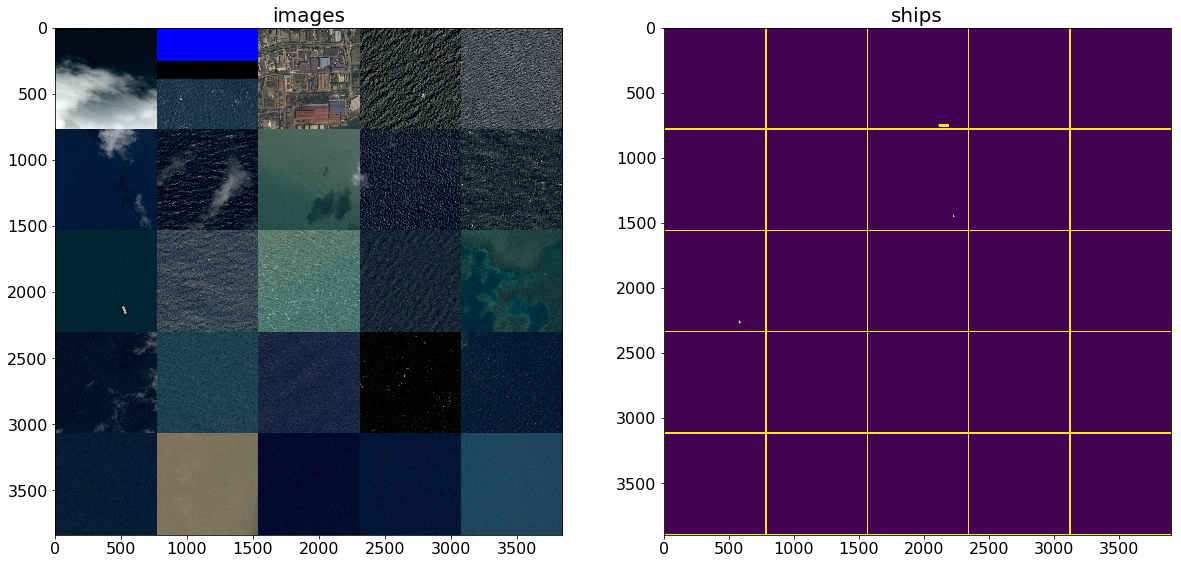

In [343]:
t_x, t_y, img_ids, seg_cts = train_gen[112]
print(t_x.shape, t_y.shape, np.min(t_x), np.min(t_y), np.max(t_x), np.max(t_y))

img_gaussian_mask = get_gaussian_mask((768, 768), scale=0.1, sigma=1.5)
seg_gaussian_mask = get_gaussian_mask((768, 768), sigma=1.5)
record_weights = get_record_weights(t_x, t_y, img_gaussian_mask, seg_gaussian_mask)

sindices = np.argsort(record_weights)[::-1]
t_x_sorted = t_x[sindices]
t_y_sorted = t_y[sindices]
img_ids_sorted = np.asarray(img_ids)[sindices]
seg_cts_sorted = np.asarray(seg_cts)[sindices]
print_stats(t_x_sorted, t_y_sorted, img_ids_sorted, seg_cts_sorted, img_gaussian_mask, seg_gaussian_mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x_sorted))
ax1.set_title('images')
ax2.imshow(montage(t_y_sorted[..., 0] + 0.5 * t_y_sorted[..., 1], padding_width=10, fill=1))
ax2.set_title('ships')

In [265]:
t0 = time.time()
record_weights0 = get_record_weights0(t_x, t_y, img_gaussian_mask, seg_gaussian_mask)
t1 = time.time()
record_weights = get_record_weights(t_x, t_y, img_gaussian_mask, seg_gaussian_mask)
print(t1-t0)
print(time.time() - t1)
print(record_weights0)
print(record_weights)

2 float64 (9, 768, 768) 0.1565384864807129
5 float64 (9, 3) 0.0856482982635498
6 float64 (9, 768, 768, 3) 0.09012174606323242
8 float64 (9, 768, 768) 0.1425189971923828
0.5229213237762451
0.5401210784912109
[19.48898148530398, 7.065698257854509, 51.76743556493532, 4.842447092506585, 4.234926052272264, 55.76559214319877, 47.23894747134436, 72.1407072782308, 18.422683355487287]
[19.48898149  7.06569826 51.76743556  4.84244709  4.23492605 55.76559214
 47.23894747 72.14070728 18.42268336]


In [16]:
t0 = time.time()

img_gaussian_mask = get_gaussian_mask((768, 768), scale=0.1, sigma=1.5)
seg_gaussian_mask = get_gaussian_mask((768, 768), sigma=1.5)
all_img_ids = []
all_weights = []
all_seg_cts = []
for i in range(len(train_gen)):
    t_x, t_y, img_ids, seg_cts = train_gen[i]
    if i % 10 == 0:
        break
        print(i, len(train_gen), len(all_img_ids), len(all_weights), time.time() - t0)
        t0 = time.time()
    record_weights = get_record_weights(t_x, t_y, img_gaussian_mask, seg_gaussian_mask)
    pixel_cts = [np.sum(y > 0.25, axis=-1) for y in t_y]
    all_img_ids += img_ids
    all_weights += record_weights
    all_seg_cts += seg_cts
    all_pixels += pixel_cts

0 1119 0 0 3.296971559524536
50 1119 4650 4650 309.56966733932495
100 1119 9300 9300 314.5818145275116
150 1119 13950 13950 319.6328728199005
200 1119 18600 18600 331.6656422615051
250 1119 23250 23250 325.7789258956909
300 1119 27900 27900 331.8230051994324
350 1119 32550 32550 315.02444338798523
400 1119 37200 37200 310.55404329299927
450 1119 41850 41850 310.3969302177429
500 1119 46500 46500 308.33159017562866
550 1119 51150 51150 310.6218750476837
600 1119 55800 55800 307.03579473495483
650 1119 60450 60450 308.18312644958496
700 1119 65100 65100 308.95930457115173
750 1119 69750 69750 308.721880197525
800 1119 74400 74400 310.29349184036255
850 1119 79050 79050 306.72611951828003
900 1119 83700 83700 308.6914529800415
950 1119 88350 88350 309.82149934768677
1000 1119 93000 93000 308.44187808036804
1050 1119 97650 97650 311.78389167785645
1100 1119 102300 102300 310.18303966522217


In [17]:
file_name = f"image_weights_{len(all_img_ids)}_i0.5_s1.5.csv" 

In [18]:
all_ids_weights_cts = OrderedDict(
    [('ImageId', all_img_ids), ('weights', all_weights), ('ships', all_seg_cts), ('pixels', all_pixels)])
all_ids_weights_cts = pd.DataFrame.from_dict(all_ids_weights_cts)

In [19]:
all_ids_weights_cts.to_csv(file_name, index=False)
all_ids_weights_cts.describe()

,ImageId,weights,counts
0,00003e153.jpg,9.518343,0
1,000155de5.jpg,71.944780,1
2,00021ddc3.jpg,89.124879,9
3,0002756f7.jpg,44.216785,2
4,0002d0f32.jpg,81.037587,0
